In [ ]:
# Importing Pandas library:
import pandas as pd

###Loading data

In [ ]:
from pathlib import Path

data_dir = "data"
# check that the path is correct
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
!wget -P $data_dir https://raw.githubusercontent.com/amirshnll/Drug-Review-Dataset/main/drugsComTest_raw.tsv
!wget -P $data_dir https://raw.githubusercontent.com/amirshnll/Drug-Review-Dataset/main/drugsComTrain_raw.tsv

--2022-08-04 14:01:51--  https://raw.githubusercontent.com/amirshnll/Drug-Review-Dataset/main/drugsComTest_raw.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28071166 (27M) [text/plain]
Saving to: ‘data/drugsComTest_raw.tsv.2’

drugsComTest_raw.ts 100%[===================>]  26.77M   169MB/s    in 0.2s    

2022-08-04 14:01:51 (169 MB/s) - ‘data/drugsComTest_raw.tsv.2’ saved [28071166/28071166]

--2022-08-04 14:01:51--  https://raw.githubusercontent.com/amirshnll/Drug-Review-Dataset/main/drugsComTrain_raw.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awai

In [ ]:
# Converting data to pd dframes:

train = pd.read_csv("data/drugsComTrain_raw.tsv", sep = "\t")
test = pd.read_csv("data/drugsComTest_raw.tsv", sep = "\t")

In [ ]:
train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [ ]:
train.shape # looking ath number of entries in the dataset

(161297, 7)

In [ ]:
# Importing the Huggingface Transformers library

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.21.0



In [ ]:
# Importing transformers and other libraries:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Defining a function to categorize ratings as sentiments "negative" (<=4), neutral (> 4 and < 7), "positive" (>= 7)

def rating_to_sent(rating):
  rating = int(rating)
  if rating <= 4:
    return "negative"
  elif rating > 4 and rating < 7:
    return "neutral"
  elif rating >= 7:
    return "positive"

In [ ]:
# Applying our function to the ratings column in training and test sets:

train['sentiment'] = train.rating.apply(rating_to_sent)
test['sentiment'] = test.rating.apply(rating_to_sent)

In [ ]:
train.head() # we can see that the "sentiment" column classifies ratings as either 0 ("negative"), 2 ("positive"), or 1 ("neutral")

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,positive


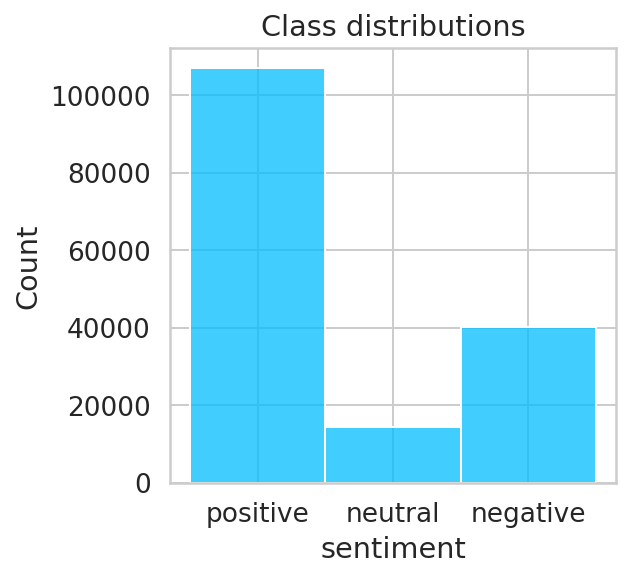

In [ ]:
#Histogram of the differenr classes
plt.figure(figsize = (4,4))
sns.histplot(train.sentiment)
plt.title("Class distributions")
plt.show()

The classes are highly imbalanced. There are very few neutral reviews. This may affect the results.

In [ ]:
#label encoding the sentiment analysis column into different multi-classes (0,1,3) and adding the column Lebl to the dataframe
le = preprocessing.LabelEncoder()

train['label'] = le.fit_transform(train['sentiment'])
test['label'] = le.transform(test['sentiment'])

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Splitting Data

In [ ]:
#spliiting our train data into 75% train set and 25% validation set
df_train, df_val = train_test_split(train, test_size=0.25, random_state=RANDOM_SEED)


###Initializing maximum length of the text in review column

In [ ]:
#creating an empty dictionary for token length
token_lens = []

for txt in train.review:
  tokens = tokenizer.encode(txt,truncation=True,max_length = 512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


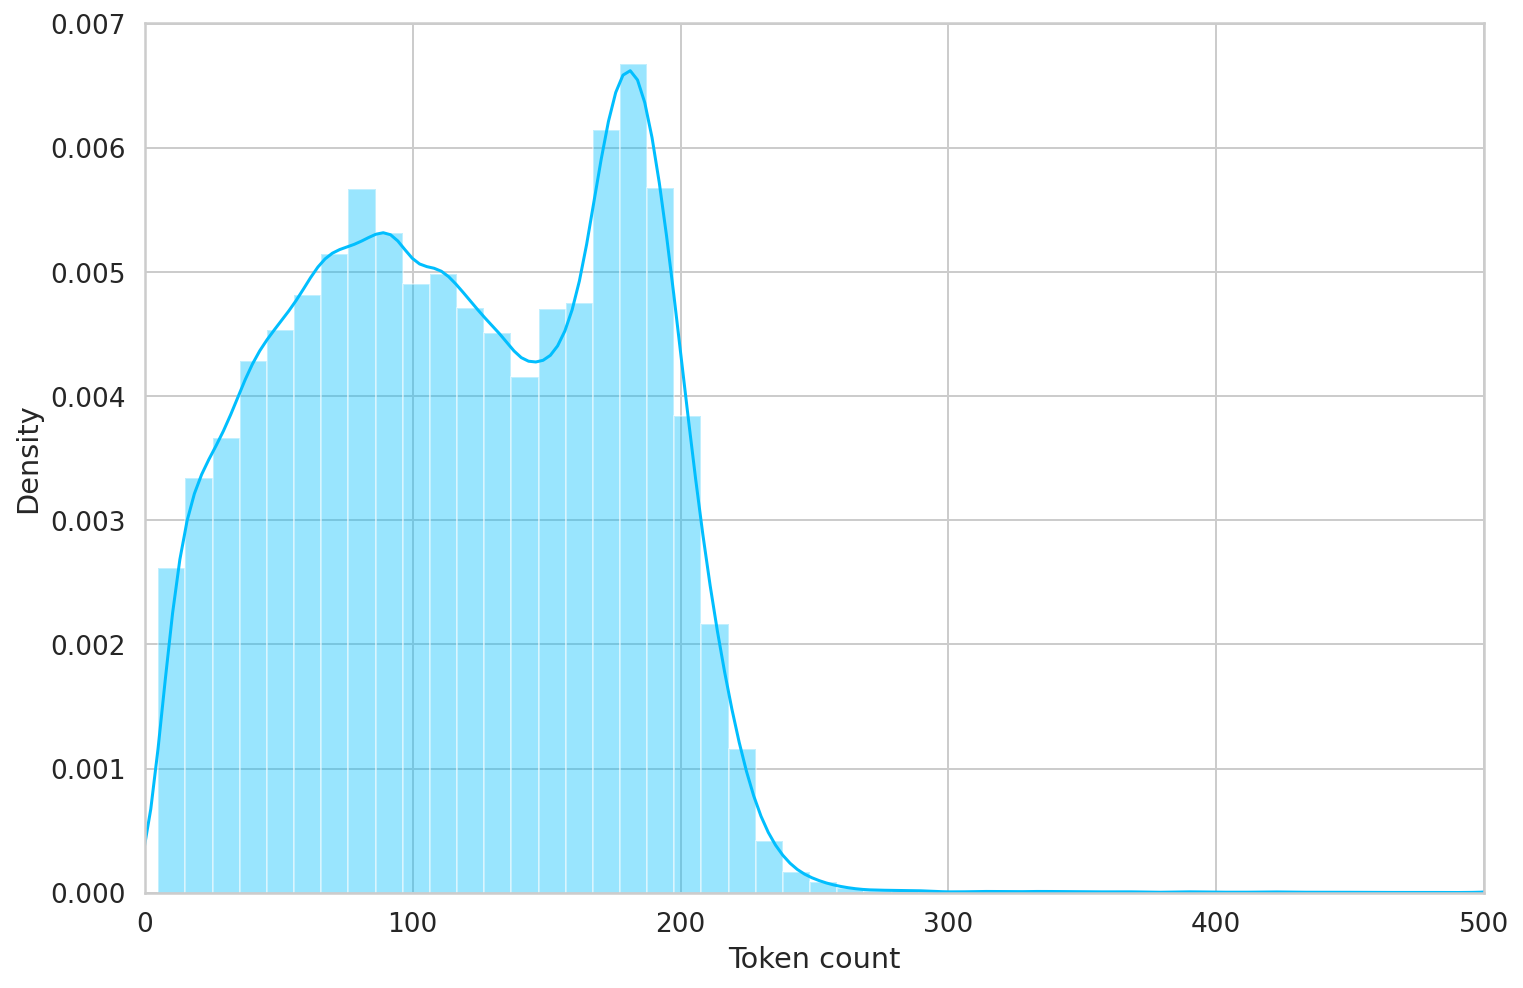

In [ ]:
#Density plot for tokens_length
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count');

Here we observed that the appropriate maximum length for the tokens is nearly "280"

###Tokenization

In [ ]:
# loading pretrained BertTokenizer: We used small small model for our prediction
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

In [ ]:
class DrugReviewDataset(Dataset):
  '''
  Intializing the attributes for our text content(review column in our dataframe),target which are labels, tokenizer(BertTokenizer)
  and maximum length including panding and truncation.This function will return a dictionary after tokenizating the data into review_text,input ids,
  attention_masks and target_ids
  '''

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment,label
56300,223288,Cetirizine,Allergic Rhinitis,"""I would just like to add a positive review in...",9.0,"November 30, 2016",10,positive,2
91115,192481,Drospirenone / ethinyl estradiol,Birth Control,"""I have been taking Gianvi for 9 months now. T...",8.0,"December 7, 2013",19,positive,2
4658,62089,Citalopram,Anxiety and Stress,"""I&#039;m a 25 year old female and my doctor p...",7.0,"September 1, 2014",102,positive,2
26163,74616,Wellbutrin SR,Depression,"""Dopamine and norepinephrine are two major bra...",9.0,"September 3, 2017",25,positive,2
122972,116207,Adalimumab,Psoriasis,"""Worked good for about 4 months then my psoria...",5.0,"April 28, 2016",8,neutral,1


In [ ]:
'''
Tokenizing Training dataframe
'''
train_ds = DrugReviewDataset(
    reviews=df_train.review.to_numpy(),
    targets=df_train.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=280)

In [ ]:
'''
Tokenizing validation dataframe
'''
val_ds = DrugReviewDataset(
    reviews=df_val.review.to_numpy(),
    targets=df_val.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=280)

In [ ]:
'''
Tokenizing test dataframe
'''
test_ds = DrugReviewDataset(
    reviews=test.review.to_numpy(),
    targets=test.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=280)

In [ ]:
val_ds[0] #looking at only one sentence in the validation tokenizer

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  10

In [ ]:
train_ds[0]#looking at only one sentence in the train tokenizer

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  10

###Data Loader : using Pytorch library

In [ ]:
ds_train=DataLoader(train_ds,batch_size=16,shuffle=False)

In [ ]:
ds_val=DataLoader(val_ds,batch_size=16,shuffle=False)


In [ ]:
ds_test=DataLoader(test_ds,batch_size=16,shuffle=False)

In [ ]:
#iterating over the pytorch dataloader
for batch in ds_train:
  print(batch)
  break

{'review_text': ['"I would just like to add a positive review in the midst of all the bad one. I realize that everybody react differentlyto each medicine, so I would like to say that I&#039;m one of the people that had no symtomps whatsoever upon taking this medicine. I have severe rhinitis allergy and have been taking lots of other antihistamines. Cetrizine have work really well with me, all of the other literally made me sleep in the middle of the day! Minimal drowziness, and very effective except for some days where my allergy is so severe, I had to take the medication twice because the first one didn&#039;t work but this is a very rare case. So please don&#039;t hesitate to try it might work really well for you too!"', '"I have been taking Gianvi for 9 months now. This is the first Birth control I tried and was highly recommended by my Gynecologist. After the first few months of taking it I didn&#039;t seem to have any problems my period always came on the third day of the placebo 

##Training the Model

In [ ]:
class SentimentClassifier(nn.Module):
  '''
  Sentiment classifcation on pretrained Bertmodel(We used small model for our datasets), adding hidden layer and droupout layer.
  We use a dropout layer for some regularization and a fully-connected layer for our output.
  Note that we’re returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.
  '''

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    intermediate = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = intermediate.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
'''Defining the class names and taking only 3 labels(len(class_names)),
 creating an instance and move it to the GPU
'''
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(model) #printing our model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affin

In [ ]:
#training
EPOCHS = 5 #intializing 5 epochs

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) #using pytorch Adamw optimizer
total_steps = len(ds_train) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    ds_train,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    ds_val,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc #took 2minutes for 2% and for whole datset it took 1h 55min 7s

Epoch 1/5
----------
Train loss 0.5044384145449747 accuracy 0.8094352412128427
Val   loss 0.4256422536337555 accuracy 0.8389832610043397

Epoch 2/5
----------
Train loss 0.39595872674897586 accuracy 0.8521145389015641
Val   loss 0.4110326105237409 accuracy 0.8496962182269063

Epoch 3/5
----------
Train loss 0.3354075779777349 accuracy 0.8766243428231327
Val   loss 0.41626705158611216 accuracy 0.857061376317421

Epoch 4/5
----------
Train loss 0.29101565692757564 accuracy 0.8948599675958073
Val   loss 0.4275024077036403 accuracy 0.8621698698078115

Epoch 5/5
----------
Train loss 0.26044686521739635 accuracy 0.9095989154515095
Val   loss 0.453836449514114 accuracy 0.8636825790452572

CPU times: user 1h 54min 48s, sys: 18.6 s, total: 1h 55min 7s
Wall time: 1h 55min 47s


In [ ]:
def get_predictions(model, data_loader):
  '''
  evaluating the model and the function give review_text,predictions,prediction_probs and real_values
  '''
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
#getting prediction on test sample
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,ds_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names)) #classification report

              precision    recall  f1-score   support

    negative       0.81      0.86      0.84     13497
     neutral       0.46      0.39      0.42      4829
    positive       0.93      0.93      0.93     35440

    accuracy                           0.86     53766
   macro avg       0.74      0.73      0.73     53766
weighted avg       0.86      0.86      0.86     53766



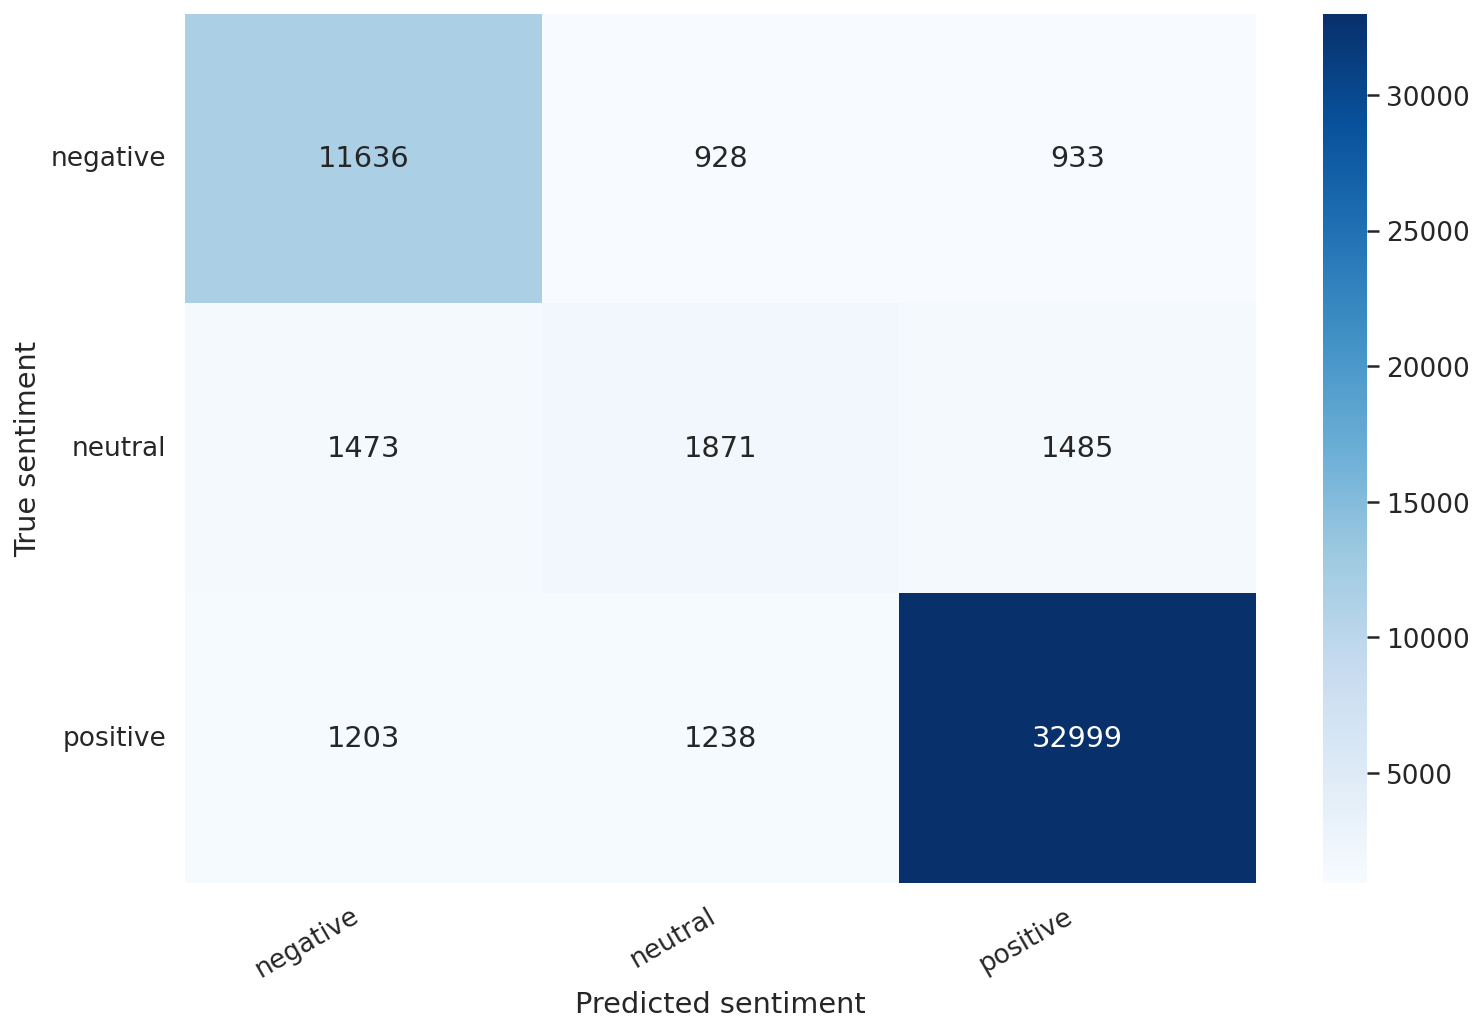

In [ ]:
def show_confusion_matrix(confusion_matrix):
  '''
  Confusion matrix to determine the test sample prediction
  '''
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


##Conclusion

1. For our Model training and Validation Loss were improved by running it for subsequent Epochs. And it took almost 2 hours to train our model(using small-bert model)
2. By looking at our classification report we concluded that our model is not able to significantly distinguish Neutral sentiments (f1 score: 42%) as compared to Negative(f1 score: 84%) and positive sentiments with 93% f1 score. The reason may be we have less number of sample for Neutral class in our dataset (Highly imbalanced)
3. By looking at the confusion matrix it confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive. There is also high percentage of Falsely predicted sentiments for overall dataset




